In [84]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


conn_deliveroo = sqlite3.connect(r'../databases/deliveroo.db')
conn_takeaway = sqlite3.connect(r'../databases/takeaway.db')
conn_ubereats = sqlite3.connect(r'../databases/ubereats.db')  
# Query for deliveroo 
query_deliveroo = """
SELECT res.postal_code as postal_code, COUNT(distinct res.id) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN restaurants res on res.id = ltr.restaurant_id
JOIN locations l on l.id = ltr.location_id
GROUP BY postal_code
ORDER BY restaurant_count DESC;
"""

# Query for takeaway
query_takeaway = """
SELECT l.postalCode as postal_code, COUNT(distinct res.primarySlug) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN locations l ON l.id = ltr.location_id
JOIN restaurants res on res.primarySlug = ltr.restaurant_id
GROUP BY l.postalCode
ORDER BY restaurant_count DESC;
"""

# Query for ubereats
query_ubereats = """
SELECT l.region as postal_code, COUNT(distinct res.id) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN locations l on l.id = ltr.location_id
JOIN restaurants res on res.id = ltr.restaurant_id
GROUP BY postal_code
ORDER BY restaurant_count DESC;
"""

deliveroo_data = pd.read_sql_query(query_deliveroo, conn_deliveroo)
takeaway_data = pd.read_sql_query(query_takeaway, conn_takeaway)
ubereats_data = pd.read_sql_query(query_ubereats, conn_ubereats)


# Add a source column to each DataFrame to differentiate between the databases
deliveroo_data['source'] = 'Deliveroo'
takeaway_data['source'] = 'Takeaway'
ubereats_data['source'] = 'UberEats'

# get city names from takeaway db
query_city_mapping = """
SELECT city, postalCode as postal_code FROM locations;
"""
city_mapping_df = pd.read_sql_query(query_city_mapping, conn_takeaway)


conn_deliveroo.close()
conn_takeaway.close()
conn_ubereats.close()

# Combine all and Map the postal codes to cities for all datasets
combined_data = pd.concat([deliveroo_data, takeaway_data, ubereats_data])
combined_data['postal_code'] = combined_data['postal_code'].astype(str)

combined_data

,postal_code,restaurant_count,source
0,2000,459,Deliveroo
1,9000,426,Deliveroo
2,3000,229,Deliveroo
3,8000,189,Deliveroo
4,2018,128,Deliveroo
...,...,...,...
435,2890,1,UberEats
436,2431,1,UberEats
437,2370,1,UberEats
438,2235,1,UberEats


### What is the distribution of restaurants per location?
### Compare restaurant distributions across UberEats, Deliveroo, and Takeaway. What are some of the market trends


<Figure size 1200x600 with 0 Axes>

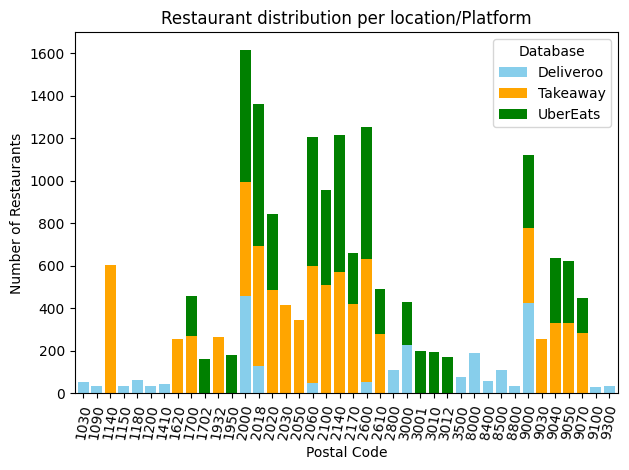

In [85]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


conn_deliveroo = sqlite3.connect(r'../databases/deliveroo.db')
conn_takeaway = sqlite3.connect(r'../databases/takeaway.db')
conn_ubereats = sqlite3.connect(r'../databases/ubereats.db') 

# Query for deliveroo 
query_deliveroo = """
SELECT res.postal_code as postal_code, COUNT(distinct res.id) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN restaurants res on res.id = ltr.restaurant_id
JOIN locations l on l.id = ltr.location_id
GROUP BY postal_code
ORDER BY restaurant_count DESC
Limit 20;
"""

# Query for takeaway
query_takeaway = """
SELECT l.postalCode as postal_code, COUNT(distinct res.primarySlug) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN locations l ON l.id = ltr.location_id
JOIN restaurants res on res.primarySlug = ltr.restaurant_id
GROUP BY l.postalCode
ORDER BY restaurant_count DESC
Limit 20;
"""

# Query for ubereats
query_ubereats = """
SELECT l.region as postal_code, COUNT(distinct res.id) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN locations l on l.id = ltr.location_id
JOIN restaurants res on res.id = ltr.restaurant_id
GROUP BY postal_code
ORDER BY restaurant_count DESC
Limit 20;
"""

deliveroo_data = pd.read_sql_query(query_deliveroo, conn_deliveroo)
takeaway_data = pd.read_sql_query(query_takeaway, conn_takeaway)
ubereats_data = pd.read_sql_query(query_ubereats, conn_ubereats)


# Add a source column to each DataFrame to differentiate between the databases
deliveroo_data['source'] = 'Deliveroo'
takeaway_data['source'] = 'Takeaway'
ubereats_data['source'] = 'UberEats'

# get city names from takeaway db
query_city_mapping = """
SELECT city, postalCode as postal_code FROM locations;
"""
city_mapping_df = pd.read_sql_query(query_city_mapping, conn_takeaway)

# mapping of postal codes to city names - not work correctly TO BE DONE later!
postal_code_to_city = dict(zip(city_mapping_df['postal_code'], city_mapping_df['city']))

conn_deliveroo.close()
conn_takeaway.close()
conn_ubereats.close()

# Combine all and Map the postal codes to cities for all datasets
combined_data = pd.concat([deliveroo_data, takeaway_data, ubereats_data])
combined_data['postal_code'] = combined_data['postal_code'].astype(str)
combined_data['city'] = combined_data['postal_code'].map(postal_code_to_city).fillna(combined_data['postal_code'])
pivot_data = combined_data.pivot_table(index='city', columns='source', values='restaurant_count', aggfunc='sum', fill_value=0)


plt.figure(figsize=(12, 6))
ax = pivot_data.plot(kind='bar', stacked=True, color=['skyblue', 'orange', 'green'], width=0.8)
plt.xlabel('Postal Code')
plt.ylabel('Number of Restaurants')
plt.title('Restaurant distribution per location/Platform')
plt.xticks(rotation=80)
plt.legend(title="Database")
plt.tight_layout()
plt.show()


### Conclusion

- **Antwerp** and **Ghent (Destelbergen**) stand out as having the highest count of restaurants, showcasing the food delivery market across all platforms for these cities.

- Certain cities like **Ostend**, **Bruges**, **Kortrijk**, **Mechelen**, **Sint-Niklaas**, and **Aalst** are commonly serviced by Deliveroo alone, with no presence from the other platforms and having lower count of restaurants comparing to other cities.

- Cities such as **Brussels (Evere)** and **Drogenbos** feature Takeaway as the exclusive delivery service.

- Interestingly, **Leuven** appears to be fully served by UberEats, as indicated by the strong green color in the plot, with no data for other delivery services.

### Next step to show geo map for these findings

TODO: invistigate more to git rid of the below error and fix dependencies, however the map is not affected and appears correctly.

                                        geo_point_2d geo_shape postcode  \
0  { "lon": 4.9783055252481603, "lat": 50.1452292...      None     5571   
1  { "lon": 4.8230406770976213, "lat": 50.5180215...      None     5080   
2  { "lon": 4.8445957515397984, "lat": 50.1654917...      None     5543   
3  { "lon": 5.2482180291084672, "lat": 51.0900989...      None     3581   
4  { "lon": 5.173248093354319, "lat": 51.04768605...      None     3583   

   special_code smun_code reg_code prov_code arr_code mun_code smun_area_code  \
0             0    91013H    03000     90000    91000    91013            BEL   
1             0    92141A    03000     90000    92000    92141            BEL   
2             0    91142E    03000     90000    91000    91142            BEL   
3             0    71004D    02000     70000    71000    71004            BEL   
4             0    71004B    02000     70000    71000    71004            BEL   

   ... prov_name_de prov_name_nl   prov_name_fr arr_name_de ar

CRSError: The EPSG code is unknown. PROJ: proj_create_from_database: Cannot find proj.db

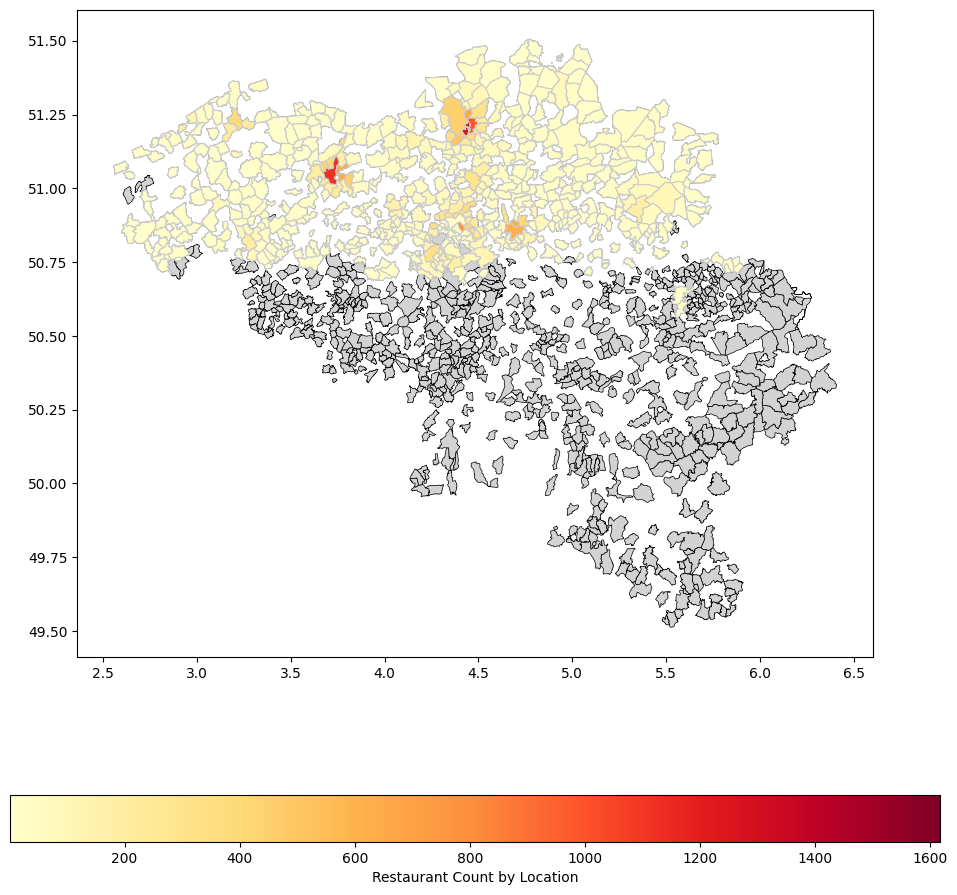

In [86]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


conn_deliveroo = sqlite3.connect(r'../databases/deliveroo.db')
conn_takeaway = sqlite3.connect(r'../databases/takeaway.db')
conn_ubereats = sqlite3.connect(r'../databases/ubereats.db') 

# Query for deliveroo 
query_deliveroo = """
SELECT res.postal_code as postal_code, COUNT(distinct res.id) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN restaurants res on res.id = ltr.restaurant_id
JOIN locations l on l.id = ltr.location_id
GROUP BY postal_code
ORDER BY restaurant_count DESC;
"""

# Query for takeaway
query_takeaway = """
SELECT l.postalCode as postal_code, COUNT(distinct res.primarySlug) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN locations l ON l.id = ltr.location_id
JOIN restaurants res on res.primarySlug = ltr.restaurant_id
GROUP BY l.postalCode
ORDER BY restaurant_count DESC;
"""

# Query for ubereats
query_ubereats = """
SELECT l.region as postal_code, COUNT(distinct res.id) AS restaurant_count
FROM locations_to_restaurants ltr
JOIN locations l on l.id = ltr.location_id
JOIN restaurants res on res.id = ltr.restaurant_id
GROUP BY postal_code
ORDER BY restaurant_count DESC;
"""

deliveroo_data = pd.read_sql_query(query_deliveroo, conn_deliveroo)
takeaway_data = pd.read_sql_query(query_takeaway, conn_takeaway)
ubereats_data = pd.read_sql_query(query_ubereats, conn_ubereats)


# Add a source column to each DataFrame to differentiate between the databases
deliveroo_data['source'] = 'Deliveroo'
takeaway_data['source'] = 'Takeaway'
ubereats_data['source'] = 'UberEats'

# get city names from takeaway db
query_city_mapping = """
SELECT city, postalCode as postal_code FROM locations;
"""
city_mapping_df = pd.read_sql_query(query_city_mapping, conn_takeaway)

# mapping of postal codes to city names - not work correctly TO BE DONE later!
postal_code_to_city = dict(zip(city_mapping_df['postal_code'], city_mapping_df['city']))

conn_deliveroo.close()
conn_takeaway.close()
conn_ubereats.close()

# Combine all and Map the postal codes to cities for all datasets
combined_data = pd.concat([deliveroo_data, takeaway_data, ubereats_data])
combined_data['postal_code'] = combined_data['postal_code'].astype(str)
combined_data['city'] = combined_data['postal_code'].map(postal_code_to_city).fillna(combined_data['postal_code'])


# Load the GeoJSON file containing postal code geometries
geo_df = gpd.read_file('georefpostal_codes.geojson')
print(geo_df.head())

# Aggregate the restaurant count by city
agg_data = combined_data.groupby('city').agg({'restaurant_count': 'sum'}).reset_index()

# Merge the restaurant data with the geographical data using postal codes
merged = geo_df.set_index('postcode').join(agg_data.set_index('city'), on='postcode')
fig, ax = plt.subplots(figsize=(12, 12))
merged.plot(ax=ax, color='lightgray', edgecolor='black', linewidth=0.5)

# Plot the restaurant counts using a color map
merged.plot(column='restaurant_count', ax=ax, legend=True,
            legend_kwds={'label': "Restaurant Count by Location", 'orientation': "horizontal"},
            cmap='YlOrRd', linewidth=0.8, edgecolor='0.8')


geo_df = geo_df.to_crs(epsg=3857)  # Convert to Web Mercator
cx.add_basemap(ax, crs=geo_df.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('Restaurant Distribution by Postal Code', fontsize=16)

ax.set_ylabel('')
ax.set_xticks([])  
ax.set_yticks([]) 

# Hide spines (the borders around the plot)
for spine in ax.spines.values():
    spine.set_visible(False)

# Disable grid
ax.grid(False)
ax.tick_params(left=False, bottom=False) 

plt.tight_layout()
plt.show()


In [ ]:
import certifi
certifi.where()

'd:\\GitHub\\Project-SQL\\venv\\Lib\\site-packages\\certifi\\cacert.pem'

### Conclusion

- **Antwerp** shows a high density of restaurants, marked in darker shades on the map. This reflects its status as a major urban center and tourist destination.
- **Brussels** As the capital, also has a significant concentration of restaurants, catering to a diverse population and international visitors.
- **Ghent** stands out as another hotspot with a strong restaurant presence.

- It was bit weird that db does not contain data for the southern region, Wallonia.


### Which restaurants have the best price-to-rating ratio?